In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from qmmc import *

## Format data

In [3]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

In [5]:
n = 3
dd = df[df["NbDealers"] == n + 1]

Y_real = dd["Y"].values

I = dd["TradeStatus"].values
II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0
I_real = II

In [6]:
m = Y_real.shape[0]
print m

44193


## Estimate model parameters from data

Using the same graphical model - with different initial values for latent variables and parameters- we now use a custom Gibbs sampler to recover the parameters.

In [7]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
a_0, b_0 = Value(1), Value(2)

# Parameters
mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=5, name='sigma_V')

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=5, name='sigma_W')

p = Beta(a_0, b_0, value=0.2, name='p')

# Variables
k = np.empty(m, dtype=object)
V = np.empty(m, dtype=object)
W = np.empty(m, dtype=object)
Y = np.empty(m, dtype=object)
I = np.empty(m, dtype=object)
for i in xrange(m):
    k[i] = Binomial(p, Value(n), name='k_%d' % i)
    V[i] = Normal(mu_V, sigma_V, name='V_%d' % i)
    W[i] = BernoulliNormal(mu_W, sigma_W, k[i], name='W_%d' % i)
    Y[i] = Value(Y_real[i])
    
    @Function
    def S_i(Y=Y[i], V=V[i], W=W[i]):
        
        if len(W) > 0:
            C = np.min(W)
        else:
            C = np.inf
        
        if Y <= np.minimum(C, V): return 2
        if C <= np.minimum(Y, V): return 1
        if V < np.minimum(C, Y): return 0
    
    I[i] = BernoulliFlip(Value(0.0), S_i, k=3, value=I_real[i], observed=True, name='I_%d' % i)

In [8]:
all_variables = [mu_V, mu_W, sigma_V, sigma_W]
all_variables.extend(V)
all_variables.extend(W)
all_variables.extend(k)
all_variables.extend([p])

In [9]:
kvw_samplers = np.empty(m, dtype=object)
for i in xrange(m):
    kvw_sampler = KVWSampler(k[i], V[i], W[i], Y[i], I[i])
    kvw_samplers[i] = kvw_sampler
p_sampler = NormalMHSampler(p, scaling=0.01)
all_samplers = list(kvw_samplers).append(p_sampler)

In [10]:
model = Model(variables=all_variables, samplers=kvw_samplers)

In [ ]:
%%time
model.estimate(100)

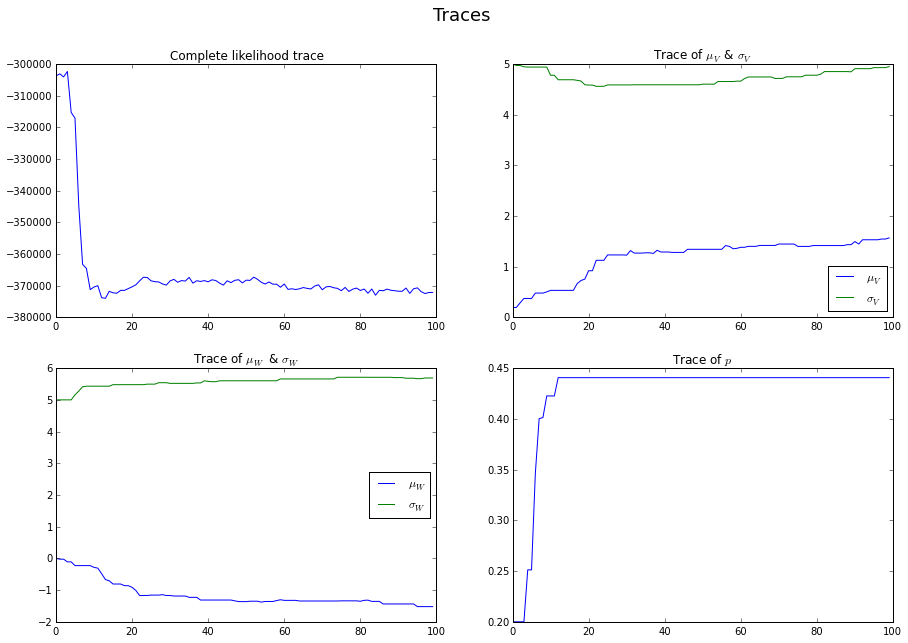

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(model.samplers['mu_V'].get_history())
plt.plot(model.samplers['sigma_V'].get_history())
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
plt.plot(model.samplers['mu_W'].get_history())
plt.plot(model.samplers['sigma_W'].get_history())
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.subplot(2, 2, 4)
plt.plot(model.samplers['p'].get_history())
plt.title(r"Trace of $p$")

plt.suptitle(r"Traces", size=18)
plt.show()